# Solving Median House Value classification problem with deep neural networks and tf.Keras

In this example we tune the neural architecture to achieve good results.

We have seen in previous examples how Keras defines the structure of a neural network as a Sequential model using the the sequential API.
However it is also possible to use the **functional API**, which is a lot more flexible. It provides complete freedom over the design of the neural network.

Code by [D. Manrique](https://orcid.org/0000-0002-0792-4156)

## Import libraries

In [2]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras
print("Tensorflow version:",tf.__version__)
print("Keras version:",keras.__version__)

#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Callbacks
from my_callbacks import TqdmProgressCallback, StopWhenValLossBelow, StopTrainingAtEpoch
from keras.callbacks import EarlyStopping

Tensorflow version: 2.20.0
Keras version: 3.13.2


## Load data

In [3]:
ATT_FILE = "FootballPlayerPreparedCleanAttributes.csv"
LABEL_FILE = "FootballPlayerOneHotEncodedClasses.csv"

TRAIN_RATE=0.8

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_dev = int((n_instances-n_train)/2)

x_train = attributes.values[:n_train]
t_train = label.values[:n_train]

x_dev = attributes.values[n_train:n_train+n_dev]
t_dev = label.values[n_train:n_train+n_dev]

print ("x_train:",x_train.shape)
print ("t_train:",t_train.shape)

print ("x_dev:",x_dev.shape)
print ("t_dev:",t_dev.shape)

x_train: (12907, 22)
t_train: (12907, 4)
x_dev: (1613, 22)
t_dev: (1613, 4)


## Initialize variables

In [4]:
INPUTS = x_train.shape[1]
OUTPUTS = t_train.shape[1]
NUM_TRAINING_EXAMPLES = int(round(x_train.shape[0]/1))
NUM_DEV_EXAMPLES = int (round (x_dev.shape[0]/1))

In [5]:
x_train[:5]

array([[-0.07317073, -0.45882353,  0.06329114,  0.23287671, -0.1       ,
         0.13253012, -0.10843373, -0.21428571,  0.10810811,  0.27710843,
        -0.09333333,  0.07317073, -0.04347826,  0.38888889, -0.13253012,
         0.41463415,  0.24390244,  0.        ,  0.31707317, -0.25      ,
        -0.10810811,  0.23809524],
       [ 0.09756098, -0.41176471,  0.08860759,  0.17808219, -0.35      ,
        -0.01204819, -0.08433735, -0.33333333,  0.08108108,  0.18072289,
        -0.01333333, -0.12195122,  0.76811594,  0.13888889, -0.22891566,
         0.53658537,  0.19512195, -0.21428571, -0.26829268, -0.1       ,
        -0.10810811,  0.28571429],
       [-0.53658537,  0.31764706,  0.3164557 , -0.12328767, -0.1       ,
         0.22891566, -0.18072289, -0.45238095, -0.40540541,  0.15662651,
        -0.09333333,  0.19512195,  0.1884058 ,  0.47222222, -0.10843373,
        -0.51219512, -0.80487805,  0.26190476, -0.34146341,  0.025     ,
        -0.40540541, -0.71428571],
       [-0.19512195

In [6]:
t_train[:10]

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

In [7]:
x_dev[:5]

array([[ 0.17073171, -0.15294118, -0.34177215,  0.45205479, -0.325     ,
         0.30120482,  0.18072289, -0.16666667,  0.40540541,  0.4939759 ,
         0.22666667,  0.2195122 ,  0.39130435,  0.30555556,  0.06024096,
         0.63414634,  0.36585366,  0.07142857,  0.36585366, -0.325     ,
         0.37837838, -0.02380952],
       [-0.07317073,  0.12941176,  0.08860759,  0.01369863,  0.05      ,
         0.42168675, -0.08433735, -0.23809524, -0.16216216,  0.3253012 ,
        -0.04      ,  0.14634146, -0.01449275, -0.13888889, -0.10843373,
         0.19512195, -0.24390244,  0.19047619, -0.02439024, -0.075     ,
        -0.24324324, -0.38095238],
       [ 0.17073171, -0.03529412,  0.24050633,  0.04109589,  0.05      ,
         0.15662651,  0.25301205,  0.11904762,  0.18918919,  0.01204819,
         0.01333333,  0.29268293, -0.42028986,  0.38888889,  0.20481928,
         0.31707317,  0.17073171,  0.        ,  0.14634146, -0.15      ,
         0.16216216,  0.28571429],
       [ 0.43902439

In [8]:
t_dev[:5]

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

## Set hyperparameters

 A 9-64-32-16-8-4 full-connected deep neural network architecture

In [32]:
n_epochs = 450
lr = 0.1
batch_size = 512
n_neurons_per_hlayer = [64, 32, 16, 8]

## Build the deep neural model

Using **the functional API**, the Input layer defines the shape of each data element to expect as a tuple.
* The Input layer defines the shape of each data element to expect as a tuple.
* The Dense layers contain a number of neurons that are densely connected to the previous layer (every unit in the layer is connected to every unit in the previous layer).

In [33]:
input_layer = keras.layers.Input(shape=(INPUTS,))
x = input_layer
for neurons in n_neurons_per_hlayer:
  x = keras.layers.Dense(units=neurons, activation = 'elu')(x)
output_layer = keras.layers.Dense(units=OUTPUTS, activation = 'softmax')(x)
model = keras.models.Model(input_layer, output_layer, name='DeepFeedForward')
model.summary()

Model: "DeepFeedForward"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 22)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,252 (16.61 KB)

 Trainable params: 4,252 (16.61 KB)

 Non-trainable params: 0 (0.00 B)

For example, the last layer's kernel comprises 78 parameters to adjust: 25 neurons in the previous layer by 3 neurons in the output layer plus the 3 biases, one for each output neuron.

## Compile the model

Available loss functions, optimizers, and metrics at: https://keras.io/losses/, https://keras.io/optimizers/ and https://keras.io/metrics/.

In [34]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
              metrics=["categorical_accuracy"])

## Train the model with M-BGD

In [35]:
from keras.callbacks import EarlyStopping
patienceStop_callback = EarlyStopping(monitor='val_loss', patience=20)
# If the val_loss does not improve for 20 consecutive epochs, the training will be stopped early.

stopWhenValLossBelow_callback = StopWhenValLossBelow(threshold=0.65)
stopTrainingAtEpoch_callback = StopTrainingAtEpoch(stop_epoch=5)

tqdm_callback = TqdmProgressCallback(epochs=n_epochs)

import time
start = time.perf_counter()
history = model.fit(x_train, t_train, 
                    batch_size=batch_size, 
                    epochs=n_epochs, 
                    verbose=0, 
                    validation_data=(x_dev, t_dev),
                   callbacks=[tqdm_callback])
print (time.perf_counter() - start)

Epochs: 100%|██████████| 450/450 [00:29<00:00, 15.31it/s]

29.427317082998343


## Get the results

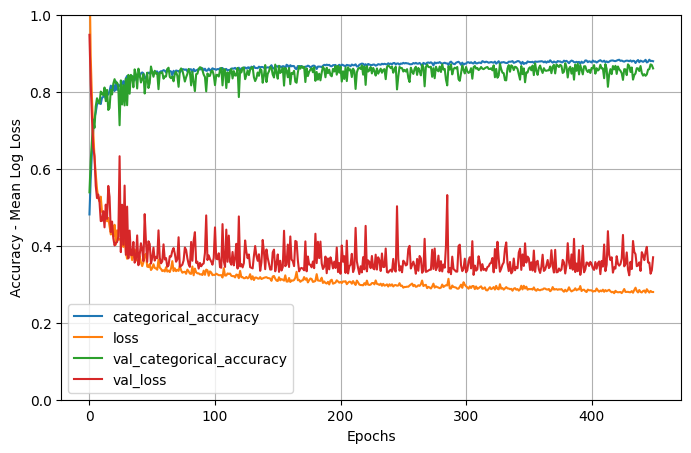

In [36]:
results=pd.DataFrame(history.history)
results.plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel ("Epochs")
plt.ylabel ("Accuracy - Mean Log Loss")
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [18]:
history.params

{'verbose': 0, 'epochs': 450, 'steps': 26}

In [19]:
results[-1:]

,categorical_accuracy,loss,val_categorical_accuracy,val_loss
449,0.884791,0.272728,0.864848,0.335737


In [20]:
print ("Accuracy for the training set: ", results.categorical_accuracy.values[-1:][0])

Accuracy for the training set:  0.8847911953926086


In [21]:
print ("Accuracy for the development test set: ", results.val_categorical_accuracy.values[-1:][0])

Accuracy for the development test set:  0.8648481369018555


Let's see how the model predicts using the development test set:

In [22]:
dev_predictions=model.predict(x_dev).round(2)
dev_predictions[:20]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step


array([[0.  , 0.  , 1.  , 0.  ],
       [0.08, 0.92, 0.  , 0.  ],
       [0.67, 0.33, 0.  , 0.  ],
       [0.  , 0.  , 0.95, 0.05],
       [0.19, 0.8 , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.83, 0.17, 0.  , 0.  ],
       [0.74, 0.26, 0.  , 0.  ],
       [0.  , 0.03, 0.95, 0.01],
       [0.55, 0.45, 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.52, 0.48, 0.  ],
       [0.  , 0.  , 0.1 , 0.9 ],
       [0.03, 0.94, 0.03, 0.  ],
       [0.  , 0.07, 0.93, 0.  ],
       [0.  , 0.1 , 0.9 , 0.  ],
       [0.99, 0.01, 0.  , 0.  ],
       [0.  , 0.26, 0.74, 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.18, 0.82, 0.  , 0.  ]], dtype=float32)

In [23]:
dev_rounded_predictions=np.round(dev_predictions)
indices = np.argmax(dev_predictions,1)
for row, index in zip(dev_rounded_predictions, indices): row[index]=1
dev_rounded_predictions[:20]

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]], dtype=float32)

In [24]:
t_dev[:20] #target classes

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [25]:
dev_correct_predictions = np.equal(np.argmax(dev_rounded_predictions,1),np.argmax(t_dev,1))
print (dev_correct_predictions[:30])

[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True False  True  True  True]


In [26]:
from collections import Counter
Counter (dev_correct_predictions)

Counter({np.True_: 1394, np.False_: 219})

## Final Test

We are suppossing that this is the final model that achieves the best performance.

### Get the final test set

In [30]:
n_final_test = n_instances-n_train-n_dev

x_final_test = attributes.values[n_train+n_dev:n_instances]
t_final_test = label.values[n_train+n_dev:n_instances]

print ("x_test:",x_final_test.shape)
print ("t_test:",t_final_test.shape)

x_test: (1614, 22)
t_test: (1614, 4)


### Evaluate the model

In [31]:
model.evaluate(x_final_test, t_final_test)

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - categorical_accuracy: 0.8476 - loss: 0.6033


[0.6032850742340088, 0.8475836515426636]

Predictions on the final test set:

In [32]:
test_predictions=model.predict(x_final_test)
test_rounded_predictions=np.round(test_predictions)
indices = np.argmax(test_predictions,1)
for row, index in zip(test_rounded_predictions, indices): row[index]=1
test_rounded_predictions[:20]

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step


array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

The target outputs:

In [33]:
t_final_test[:20]

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

The first 30 predictions. True means that the neural network correctly classifies the input vector.  

In [34]:
test_correct_predictions = np.equal(np.argmax(test_rounded_predictions,1),np.argmax(t_final_test,1))
test_correct_predictions[:30]

array([False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False])

The final test accuracy:

In [35]:
from collections import Counter
final_test_prediction_results=Counter(test_correct_predictions)
final_test_prediction_results

Counter({np.True_: 1368, np.False_: 246})

In [36]:
final_test_prediction_results[True]/sum(final_test_prediction_results.values())

0.8475836431226765

### Confusion Matrix on the final test set

In [38]:
test_sparse_predictions = np.argmax (test_predictions,axis=1)
test_sparse_targets = np.argmax(t_final_test, axis=1)
print('Confusion Matrix')
c_m=pd.DataFrame(confusion_matrix(test_sparse_predictions,test_sparse_targets),columns=['True_Poor', 'True_Good', 'True_Interme','True_Excel'])
c_m.insert(0,'Classes',['Pred_Poor', 'Pred_Good', 'Pred_Interme','Pred_Excel'])
c_m['Sum']=c_m.sum(axis=1, numeric_only=True)
c_m

Confusion Matrix


,Classes,True_Poor,True_Good,True_Interme,True_Excel,Sum
0,Pred_Poor,393,41,0,0,434
1,Pred_Good,53,266,41,0,360
2,Pred_Interme,0,48,380,26,454
3,Pred_Excel,0,0,37,329,366


### Clasification metrics

In [40]:
print('Classification Report')
classes = ['Poor', 'Good', 'Intermediate', 'Excellent']
print(classification_report(test_sparse_targets, test_sparse_predictions, target_names=classes))

Classification Report
              precision    recall  f1-score   support

        Poor       0.91      0.88      0.89       446
        Good       0.74      0.75      0.74       355
Intermediate       0.84      0.83      0.83       458
   Excellent       0.90      0.93      0.91       355

    accuracy                           0.85      1614
   macro avg       0.85      0.85      0.85      1614
weighted avg       0.85      0.85      0.85      1614



The classification metrics improve with respect to those from the one-hidden layer neural model. Again, the class *Average* achieves the worst results.